In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

from data import PiDataset
from model import TransformerVAE

### Load data

In [2]:
# load data
X = np.load('pi_xs.npy')
Y = np.load('pi_ys.npy')
image_array = np.array(Image.open('sparse_pi_colored.jpg'))
rgb_values = image_array[X, Y]

### Set hyperparameters and create model

In [3]:
# set hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"

num_layers = 2
enc_num_layers = 4
embedding_dim = 64
hidden_size = 64
num_heads = 8

num_items_enc = [301, 301, 257, 257, 257]
num_items_dec = [301, 301, 257, 257]
num_items_out = [300, 300, 256, 256, 256]
dropout_rate = 0.1
model = TransformerVAE(num_items_enc, num_items_dec, num_items_out,
                       num_layers=num_layers, enc_num_layers=enc_num_layers,
                       embedding_dim=embedding_dim, hidden_size=hidden_size,
                       num_heads=num_heads, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

pi_dataset = PiDataset(X, Y, rgb_values, embedding_dim=embedding_dim, device=device)
pi_loader = torch.utils.data.DataLoader(pi_dataset, batch_size=512, shuffle=True)

### Train model

In [4]:
model.fit(pi_loader, criterion, optimizer, verbose=2)

epoch 1/100: loss: 285.83740692138673 p_loss: 28.627201271057128 z_loss: 56.81979961395264 
epoch 11/100: loss: 208.14240264892578 p_loss: 25.475418853759766 z_loss: 4.339051103591919 
epoch 21/100: loss: 193.20946044921874 p_loss: 23.839165687561035 z_loss: 2.4961353302001954 
epoch 31/100: loss: 171.03445129394532 p_loss: 21.245508003234864 z_loss: 1.0703860163688659 
epoch 41/100: loss: 159.16397552490236 p_loss: 19.833894729614258 z_loss: 0.4928193598985672 
epoch 51/100: loss: 150.90518035888672 p_loss: 18.8209529876709 z_loss: 0.3375571608543396 
epoch 61/100: loss: 143.9152084350586 p_loss: 17.95344467163086 z_loss: 0.28765197843313217 
epoch 71/100: loss: 138.16753082275392 p_loss: 17.238892364501954 z_loss: 0.2563938021659851 
epoch 81/100: loss: 133.15282440185547 p_loss: 16.615529441833495 z_loss: 0.2285882607102394 
epoch 91/100: loss: 129.17203369140626 p_loss: 16.116259765625 z_loss: 0.24195607453584672 
loss: 125.86169509887695 p_loss: 15.70366907119751 z_loss: 0.2323421

### Generated image

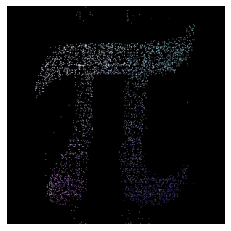

In [5]:
img_data = np.zeros((300, 300, 3), dtype=np.uint8)
for _ in range(100):
    noises = torch.randn(100000, 1, embedding_dim).to(device)
    q = model.generate(noises)
    img_data[q[:, 0], q[:, 1]] = q[:, 2:]

plt.axis('off')
plt.imshow(Image.fromarray(img_data))

### Source image

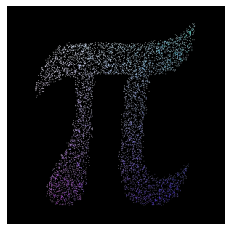

In [6]:
# source image
img_data = np.zeros((300, 300, 3), dtype=np.uint8)
img_data[X, Y] = rgb_values
plt.axis('off')
plt.imshow(Image.fromarray(img_data))